In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
import sklearn
import seaborn as sns
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 5e-5 #LEARNING_RATE
NUM_EPOCHS = 100
CRITIC_ITERATIONS = 5
batch_size = 64
z_size = 5
nfeatures = 14 # just generate pca comps


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **LOAD DATA** 

In [ ]:



data_path = "/content/drive/MyDrive/gan/probe_Preprocesstrain "
reduced_set = pd.read_csv(data_path)


reduced_set.drop(["Unnamed: 0"],axis=1,inplace=True)
reduced_set

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
0,-0.001520,0.000418,-0.000149,0.004145,0.008246,0.001988,0.000921,0.000379,-0.000764,-0.002540,-0.000797,0.001912,0.000909,0.000832,normal
1,-0.001115,0.003081,0.000571,0.002182,-0.002259,0.001362,0.002101,0.004391,0.000898,0.001334,-0.001681,0.001475,-0.004288,0.014168,normal
2,0.001572,-0.001741,0.000062,0.002850,-0.001820,-0.001214,0.000802,0.000628,-0.003891,-0.000169,0.001835,0.001105,-0.000820,-0.001623,normal
3,0.000630,-0.000501,0.000133,-0.005372,-0.000135,0.000121,0.000390,-0.000176,-0.002399,-0.000239,0.000444,-0.000019,-0.000207,-0.000245,normal
4,-0.000460,-0.000789,-0.000463,0.002849,-0.001981,-0.000701,-0.000166,0.000418,-0.003125,-0.000120,0.002211,-0.003655,-0.000360,-0.000494,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78994,-0.004620,-0.000291,0.005279,-0.003234,-0.003127,-0.004490,-0.015451,0.000864,0.000909,-0.000155,0.000052,0.003743,-0.004498,0.001998,normal
78995,0.000767,-0.002304,-0.000934,0.003481,-0.004862,-0.002065,0.001261,0.000101,-0.003717,-0.000886,0.000207,-0.000690,0.000063,-0.000106,normal
78996,0.000612,-0.000587,0.006855,-0.001187,-0.000250,0.006703,0.001487,0.003119,0.001320,-0.001157,-0.000017,0.001475,-0.000511,-0.000032,normal
78997,0.003538,-0.000979,0.002285,-0.002170,0.005524,-0.003466,-0.002271,-0.001224,-0.000334,-0.002439,-0.002971,-0.002681,0.001539,0.001266,normal


In [ ]:
attack_data = reduced_set[reduced_set.attack!="normal"]
attack_data



,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
6,-0.012126,-0.000456,0.002117,-0.001636,0.003987,-0.001891,-0.008318,0.000931,0.000309,0.000470,0.001621,0.010438,-0.004505,-0.002193,ipsweep
15,-0.013574,-0.000371,-0.000080,-0.000586,0.000737,-0.000604,-0.003139,-0.000186,0.001115,-0.000129,0.000695,-0.001975,-0.001010,-0.000736,ipsweep
17,0.001086,-0.001384,0.001721,0.000404,0.000733,-0.000412,-0.000198,0.001113,-0.000044,0.008918,-0.004471,0.000041,0.019646,-0.000050,portsweep
30,-0.012594,-0.000368,-0.000342,-0.000081,0.000123,-0.000473,-0.003239,-0.000787,0.001066,-0.000566,0.000396,-0.002697,0.000567,-0.000128,nmap
33,0.000586,0.000081,0.000808,-0.000090,0.000727,-0.000370,0.000971,0.001455,0.000272,0.015687,-0.000910,0.000342,0.005520,-0.000242,satan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78912,-0.001535,-0.001060,0.002479,0.004658,0.006765,-0.001195,-0.000040,0.003158,-0.000997,0.007920,-0.008520,0.001924,-0.012126,-0.011325,ipsweep
78918,-0.001565,-0.000995,0.002471,0.004652,0.006753,-0.001209,-0.000041,0.003206,-0.001001,0.007933,-0.008525,0.001953,-0.012378,-0.011367,ipsweep
78940,0.000156,0.002190,0.000751,-0.001038,-0.001938,-0.002476,0.000353,-0.000590,-0.000125,-0.001285,-0.013931,0.000661,0.001118,-0.000158,portsweep
78955,-0.013482,-0.000407,-0.000066,-0.000357,0.000556,-0.000633,-0.002414,-0.000281,0.000952,-0.000176,0.000650,-0.001959,-0.000992,-0.000694,ipsweep


In [ ]:
attack_data.drop(columns = ["attack"],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
attack_data

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14
6,-0.012126,-0.000456,0.002117,-0.001636,0.003987,-0.001891,-0.008318,0.000931,0.000309,0.000470,0.001621,0.010438,-0.004505,-0.002193
15,-0.013574,-0.000371,-0.000080,-0.000586,0.000737,-0.000604,-0.003139,-0.000186,0.001115,-0.000129,0.000695,-0.001975,-0.001010,-0.000736
17,0.001086,-0.001384,0.001721,0.000404,0.000733,-0.000412,-0.000198,0.001113,-0.000044,0.008918,-0.004471,0.000041,0.019646,-0.000050
30,-0.012594,-0.000368,-0.000342,-0.000081,0.000123,-0.000473,-0.003239,-0.000787,0.001066,-0.000566,0.000396,-0.002697,0.000567,-0.000128
33,0.000586,0.000081,0.000808,-0.000090,0.000727,-0.000370,0.000971,0.001455,0.000272,0.015687,-0.000910,0.000342,0.005520,-0.000242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78912,-0.001535,-0.001060,0.002479,0.004658,0.006765,-0.001195,-0.000040,0.003158,-0.000997,0.007920,-0.008520,0.001924,-0.012126,-0.011325
78918,-0.001565,-0.000995,0.002471,0.004652,0.006753,-0.001209,-0.000041,0.003206,-0.001001,0.007933,-0.008525,0.001953,-0.012378,-0.011367
78940,0.000156,0.002190,0.000751,-0.001038,-0.001938,-0.002476,0.000353,-0.000590,-0.000125,-0.001285,-0.013931,0.000661,0.001118,-0.000158
78955,-0.013482,-0.000407,-0.000066,-0.000357,0.000556,-0.000633,-0.002414,-0.000281,0.000952,-0.000176,0.000650,-0.001959,-0.000992,-0.000694


In [ ]:
class ReducedSet(Dataset):
    def __init__(self,data):
        self.samples = list(data.values)

    def __len__(self):
        return len(list(self.samples))

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        #WHY 0.3??
        
    def forward(self, x):
        # flatten image
        # x = x.view(-1, 28*28)
        # all hidden layers
        #WHY LEAKY RELU???
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        out = self.fc4(x)

        return out


In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = nfeatures
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 10
# Size of discriminator output (generated image)
g_output_size = input_size
# Size of first hidden layer in the generator
g_hidden_size = 32

CRITIC_ITERATIONS = 5            
WEIGHT_CLIP = 0.01

In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=14, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
import torch.optim as optim


# Create optimizers for the discriminator and generator
critic_optimizer = optim.RMSprop(D.parameters(), lr)                 #1
g_optimizer = optim.RMSprop(G.parameters(), lr)

In [ ]:
train_dataset = ReducedSet(attack_data)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 80

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 10

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=2100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, real_data in enumerate(train_dataloader):
                
        real_data = real_data.float()
        batch_size = real_data.size(0)

        for _ in range(CRITIC_ITERATIONS):
          D.zero_grad()
          critic_real = D(real_data)
          
          z = np.random.uniform(-1, 1, size=(batch_size, z_size))
          z = torch.from_numpy(z).float()
          fake_data = G(z)
          #critic_real = D(real_data).reshape(-1)
          critic_fake = D(fake_data)
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
         # D.zero_grad()
          loss_critic.backward(retain_graph=True)
          critic_optimizer.step()
          



         

          # clip critic weights between -0.01, 0.01
          for p in D.parameters():
                #print(p.data)
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        G.zero_grad()
        gen_fake = D(fake_data).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        
        loss_gen.backward()
        g_optimizer.step()
        
        
      

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | loss_critic: {:6.4f} | loss_gen: {:6.4f}'.format( epoch+1, num_epochs, loss_critic.item(), loss_gen.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((loss_critic.item(), loss_gen.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode





    import csv                        #save generated data into generated file
    with open ('loss_epoch-100_dos.csv','w',newline='') as f:
       thewriter=csv.writer(f)
    
       for i in range(0,len(losses)):
        thewriter.writerow(losses[i])
        #samples.append(samples_z)
        G.train() # back to train mode
    
    # generate and save sample, fake data
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    np_arr = samples_z.cpu().detach().numpy()

    import csv                        #save generated data into generated file
    with open ('Generated_epoch-100_dos.csv','w',newline='') as f:
       thewriter=csv.writer(f)
    
       for i in range(0,len(np_arr)):
        thewriter.writerow(np_arr[i])
        #samples.append(samples_z)
        G.train() # back to train mode



Loss_Df = pd.read_csv('loss_epoch-100_dos.csv')
path = "/content/drive/MyDrive/gan/wgan/loss/optimal/"
Loss_Df.to_csv(path+"loss_epoch-100_pobe.csv",header = True,index=False)


GeneratedData_Df = pd.read_csv('Generated_epoch-100_dos.csv')
path = "/content/drive/MyDrive/gan/wgan/generated/optimal/"
GeneratedData_Df.to_csv(path+"Generated_epoch-100_pobe.csv",header = True,index=False)


Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0001 | loss_gen: 0.0097
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0095
Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0001 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: 0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: 0.0001 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0000 | loss_gen: 0.0096
Epoch [    1/   80] | loss_critic: -0.0001 | loss_gen: 0.0096
Epoch [    1/  

## **TRAINING LOSSES**

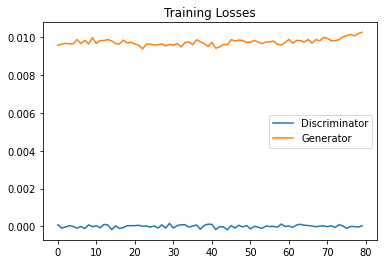

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
losses
diff=[]
for i in range(0,len(losses)):
   a=losses[i][1]-losses[i][0]
   diff.append(abs(a))
op=sorted(diff)
op

[0.009389970451593399,
 0.00939673651009798,
 0.009410826489329338,
 0.0094626909121871,
 0.009466187097132206,
 0.009494636207818985,
 0.009510945528745651,
 0.009523195214569569,
 0.009557874873280525,
 0.00956661906093359,
 0.009573183953762054,
 0.00958979967981577,
 0.009594857692718506,
 0.009602940641343594,
 0.009613638743758202,
 0.009620556607842445,
 0.00962262786924839,
 0.0096267806366086,
 0.009627141058444977,
 0.009628873318433762,
 0.009641949087381363,
 0.00964234210550785,
 0.009644107893109322,
 0.009648237377405167,
 0.009653767570853233,
 0.009662800468504429,
 0.009670266881585121,
 0.00967119075357914,
 0.00967500451952219,
 0.009682845324277878,
 0.009682992473244667,
 0.009690659120678902,
 0.009696327149868011,
 0.009696464985609055,
 0.009699760936200619,
 0.009711073711514473,
 0.009717808105051517,
 0.009724448435008526,
 0.009725390933454037,
 0.009730031713843346,
 0.009737535379827023,
 0.009737657383084297,
 0.009760623797774315,
 0.009764431975781918,

In [ ]:
for index, value in zip(range(len(diff)), diff):
    print (index, value)

0 0.009494636207818985
1 0.009724448435008526
2 0.009711073711514473
3 0.009620556607842445
4 0.009653767570853233
5 0.00997315626591444
6 0.009682845324277878
7 0.009953727014362812
8 0.009573183953762054
9 0.009995811618864536
10 0.009644107893109322
11 0.009907483123242855
12 0.009725390933454037
13 0.00981107447296381
14 0.009989534504711628
15 0.009641949087381363
16 0.009760623797774315
17 0.009916340932250023
18 0.009670266881585121
19 0.009696464985609055
20 0.009602940641343594
21 0.009523195214569569
22 0.009389970451593399
23 0.009613638743758202
24 0.009682992473244667
25 0.009557874873280525
26 0.009699760936200619
27 0.00956661906093359
28 0.00964234210550785
29 0.0094626909121871
30 0.009662800468504429
31 0.009627141058444977
32 0.009410826489329338
33 0.0096267806366086
34 0.00980366487056017
35 0.009594857692718506
36 0.00979394931346178
37 0.00991677213460207
38 0.00962262786924839
39 0.00939673651009798
40 0.009628873318433762
41 0.00958979967981577
42 0.00951094552